# CS 180 Final Project: Classifying stress levels by applying $k$-nearest neighbors using different lifestyle factors

In [440]:
import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [441]:
file_url = 'https://raw.githubusercontent.com/daryll-ko/stress/18a2bd7178aa1cfe48c027b1e2e03f9dbfeed161/Wellbeing_and_lifestyle_data_Kaggle.csv'
df = pd.read_csv(file_url)
print(df.head())

  Timestamp  FRUITS_VEGGIES DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
0    7/7/15               3            2               2            5   
1    7/7/15               2            3               4            3   
2    7/7/15               2            3               3            4   
3    7/7/15               3            3              10            3   
4    7/7/15               5            1               3            3   

   SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  ...  \
0                  0               5            2         0          1  ...   
1                  8              10            5         2          2  ...   
2                  4              10            3         2          2  ...   
3                 10               7            2         5          2  ...   
4                 10               4            2         4          2  ...   

   SLEEP_HOURS  LOST_VACATION  DAILY_SHOUTING  SUFFICIENT_INCOME  \
0            7    

## Preprocessing

In [442]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                15972 non-null  object 
 1   FRUITS_VEGGIES           15972 non-null  int64  
 2   DAILY_STRESS             15972 non-null  object 
 3   PLACES_VISITED           15972 non-null  int64  
 4   CORE_CIRCLE              15972 non-null  int64  
 5   SUPPORTING_OTHERS        15972 non-null  int64  
 6   SOCIAL_NETWORK           15972 non-null  int64  
 7   ACHIEVEMENT              15972 non-null  int64  
 8   DONATION                 15972 non-null  int64  
 9   BMI_RANGE                15972 non-null  int64  
 10  TODO_COMPLETED           15972 non-null  int64  
 11  FLOW                     15972 non-null  int64  
 12  DAILY_STEPS              15972 non-null  int64  
 13  LIVE_VISION              15972 non-null  int64  
 14  SLEEP_HOURS           

In [443]:
# Drop the 'Timestamp' field
df.drop(["Timestamp"], axis=1, inplace=True)

df.columns

Index(['FRUITS_VEGGIES', 'DAILY_STRESS', 'PLACES_VISITED', 'CORE_CIRCLE',
       'SUPPORTING_OTHERS', 'SOCIAL_NETWORK', 'ACHIEVEMENT', 'DONATION',
       'BMI_RANGE', 'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION',
       'SLEEP_HOURS', 'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME',
       'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION', 'AGE',
       'GENDER', 'WORK_LIFE_BALANCE_SCORE'],
      dtype='object')

In [444]:
# Convert 'DAILY_STRESS' field to numeric
df['DAILY_STRESS'] = pd.to_numeric(df['DAILY_STRESS'], errors='coerce')

print(df['DAILY_STRESS'].describe())

count    15971.000000
mean         2.791685
std          1.367801
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: DAILY_STRESS, dtype: float64


Notice count is less than the total number of rows in the dataset.

In [445]:
# Fill mismatched value in 'DAILY_STRESS' with the integer mean of the column
average_stress = round(df['DAILY_STRESS'].mean())
df['DAILY_STRESS'].fillna(average_stress, inplace=True)

In [446]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'GENDER' and 'AGE' field
df['GENDER'] = label_encoder.fit_transform(df['GENDER'])    # 0: Female, 1: Male
df['AGE'] = label_encoder.fit_transform(df['AGE'])          # 1: 36-50, 2: > 50, 0: 21-35 3: < 20

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FRUITS_VEGGIES           15972 non-null  int64  
 1   DAILY_STRESS             15972 non-null  float64
 2   PLACES_VISITED           15972 non-null  int64  
 3   CORE_CIRCLE              15972 non-null  int64  
 4   SUPPORTING_OTHERS        15972 non-null  int64  
 5   SOCIAL_NETWORK           15972 non-null  int64  
 6   ACHIEVEMENT              15972 non-null  int64  
 7   DONATION                 15972 non-null  int64  
 8   BMI_RANGE                15972 non-null  int64  
 9   TODO_COMPLETED           15972 non-null  int64  
 10  FLOW                     15972 non-null  int64  
 11  DAILY_STEPS              15972 non-null  int64  
 12  LIVE_VISION              15972 non-null  int64  
 13  SLEEP_HOURS              15972 non-null  int64  
 14  LOST_VACATION         

In [447]:
X = df.drop(['DAILY_STRESS'], axis = 1)
y = df['DAILY_STRESS']

In [448]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})

# Sort by importance
feature_importances = feature_importances.sort_values("importance", ascending=False)

print(feature_importances)

                    feature  importance
21  WORK_LIFE_BALANCE_SCORE    0.100395
10              DAILY_STEPS    0.054493
8            TODO_COMPLETED    0.054069
14           DAILY_SHOUTING    0.053409
2               CORE_CIRCLE    0.052764
16          PERSONAL_AWARDS    0.051987
5               ACHIEVEMENT    0.051976
1            PLACES_VISITED    0.051009
3         SUPPORTING_OTHERS    0.050857
17         TIME_FOR_PASSION    0.050261
9                      FLOW    0.050090
11              LIVE_VISION    0.049255
18        WEEKLY_MEDITATION    0.048277
4            SOCIAL_NETWORK    0.047391
0            FRUITS_VEGGIES    0.042033
6                  DONATION    0.041183
12              SLEEP_HOURS    0.038296
13            LOST_VACATION    0.036802
19                      AGE    0.033084
7                 BMI_RANGE    0.016233
20                   GENDER    0.014327
15        SUFFICIENT_INCOME    0.011812


In [449]:
# Calculate the number of top features to select
num_top_features = len(feature_importances) // 2

# Select the top half of features
top_features = feature_importances.nlargest(num_top_features, 'importance')

# Print the top features
print(top_features)

# Create a new DataFrame with only the top features
X_top_features = X[top_features['feature']]

                    feature  importance
21  WORK_LIFE_BALANCE_SCORE    0.100395
10              DAILY_STEPS    0.054493
8            TODO_COMPLETED    0.054069
14           DAILY_SHOUTING    0.053409
2               CORE_CIRCLE    0.052764
16          PERSONAL_AWARDS    0.051987
5               ACHIEVEMENT    0.051976
1            PLACES_VISITED    0.051009
3         SUPPORTING_OTHERS    0.050857
17         TIME_FOR_PASSION    0.050261
9                      FLOW    0.050090


In [450]:
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_top_features)

#scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

print(X_scaled)

[[-1.27173395 -0.24338474  0.09680089 ... -1.732447   -1.21887826
   0.34156558]
 [-0.24770956 -0.24338474 -0.28429447 ...  0.73522682 -0.48606476
  -0.50681098]
 [-0.78082421 -0.58929515 -1.42758056 ... -0.49861009  1.71237576
  -0.50681098]
 ...
 [ 1.10729018 -0.24338474  0.47789626 ...  1.35214528 -0.85247151
  -0.0826227 ]
 [ 0.33871656 -1.62702636  0.09680089 ... -1.11552855  0.97956226
   2.88669525]
 [-0.34100462 -1.62702636  0.47789626 ...  1.35214528  1.71237576
   0.34156558]]


In [451]:
X_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 1)

print(X_train.shape)
print(x_test.shape)

(11180, 11)
(4792, 11)


In [452]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train,y_train)

KNeighborsClassifier()

In [453]:
y_pred = knn.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[ 15  73  44  40  14   8]
 [ 27 210 203 177  58  24]
 [ 48 226 354 298 126  23]
 [ 36 221 331 501 159  66]
 [ 20 128 222 316 162  65]
 [  5  68  90 197 133 104]]
              precision    recall  f1-score   support

         0.0       0.10      0.08      0.09       194
         1.0       0.23      0.30      0.26       699
         2.0       0.28      0.33      0.31      1075
         3.0       0.33      0.38      0.35      1314
         4.0       0.25      0.18      0.21       913
         5.0       0.36      0.17      0.23       597

    accuracy                           0.28      4792
   macro avg       0.26      0.24      0.24      4792
weighted avg       0.28      0.28      0.28      4792



In [454]:
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

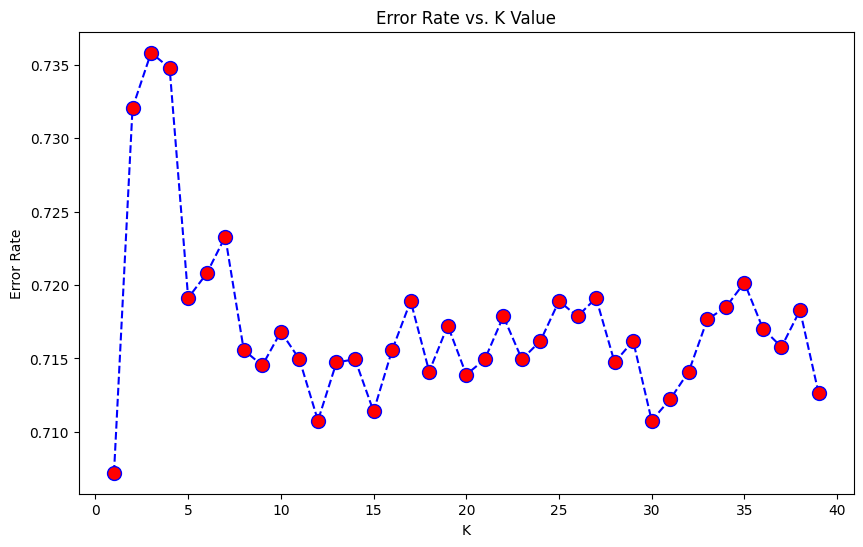

In [455]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')